This example from the pytorch documentation [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) displays generating random y ad x dat and fitting a multi-layer neural network.

In [0]:
# -*- coding: utf-8 -*-
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

99 2.1936633586883545
199 0.030526122078299522
299 0.0010051147546619177
399 5.2805262384936213e-05
499 3.4086278901668265e-06


Let's update that example for our setting using the voxel level data.

In [0]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
## this sets some style parameters
sns.set()

## Download in the data if it's not already there
! if [ ! -e oasis.csv ]; \
  then wget https://raw.githubusercontent.com/jkrachm2/Data-Science/master/Master%20Repo/ds4bme_intro-master/data/oasis.csv; \
fi;

## Read in the data and display a few rows
dat = pd.read_csv("oasis.csv")

--2020-03-23 22:32:33--  https://raw.githubusercontent.com/jkrachm2/Data-Science/master/Master%20Repo/ds4bme_intro-master/data/oasis.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22274 (22K) [text/plain]
Saving to: ‘oasis.csv’

oasis.csv           100%[===================>]  21.75K  --.-KB/s    in 0.01s   

2020-03-23 22:32:33 (1.52 MB/s) - ‘oasis.csv’ saved [22274/22274]



In [0]:
trainFraction = .75

sample = np.random.uniform(size = 100) < trainFraction
trainingDat = dat[sample]
testingDat = dat[~sample]


In [0]:
x = torch.from_numpy(dat[['PD','T1', 'T2', 'FLAIR_10', 'T1_10', 'T2_10', 'FLAIR_20']].values)
y = torch.from_numpy(dat[['FLAIR']].values)

##pytorch wants type as float
x = x.float()
y = y.float()

xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]

[
 xtraining.size(),
 ytraining.size(),
 xtesting.size(),
 ytesting.size(),
]


[torch.Size([78, 7]),
 torch.Size([78, 1]),
 torch.Size([22, 7]),
 torch.Size([22, 1])]

In [0]:
## Define the model
## Dimension of the hidden layer
H = 10

## Number of predictors
D_in = xtraining.size()[1]
D_out = 1

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)



In [0]:
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    y_pred = model(xtraining)
    loss = loss_fn(y_pred, ytraining)
    if t % 100 == 99:
        print(t, loss.item())
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad


99 29.2286319732666
199 25.58927345275879
299 24.688426971435547
399 24.08563232421875
499 23.58952522277832


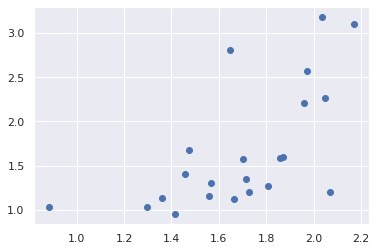

In [0]:
## try prediction
ytesting_pred = model(xtesting)
a = ytesting_pred.detach().numpy()

plt.scatter(a[:,0], ytesting[:,0])